In [13]:
from eqnemix import eqnemaster
import matplotlib.pyplot as plt
import numpy as np


# Main class

### The first thing we need to initialize the class, is the location of the station to work with

In [2]:
stax = -103.510147    #Longitude
stay = 31.408922    # latitude

eq = eqnemaster(-103.510147,31.408922, deltadist=1000)

### Then we have to define an area around the station to work with

#### Using a Shape file

In [3]:
eq.xminyminshape("extent.shp",inputcrs=4326,outputcrs=3857)

(-11669823.762683755, 3583642.4713136116, 255)

#### By providing the bottom left and the top right corner of the area

In [4]:
import geopandas as gpd
gdf = gpd.read_file("extent.shp") #Leer el archivo
polygon = gdf.geometry.iloc[0]
print(gdf.crs)
print(polygon.bounds)

EPSG:4326
(-104.83181049, 30.6211275, -102.86858939, 32.57773843)


In [5]:
eq.xminymin(-104.83181049,30.6211275,-102.86858939,32.57773843,inputcrs=4326,outputcrs=3857)

(-11669823.762683755, 3583642.4713136116, 255)

### To define the velocity grid we need the P and S velocities as well as the thickness for all the layers

In [6]:
vp_values = [5.5, 5.85, 6.5, 8.18]  
vs_values = [3.06,3.25, 3.61, 4.54]
layer_thickness = [5, 24, 10, 100]  

In [7]:
gridp, grids = eq.nllgrid(vp_values,vs_values,layer_thickness)

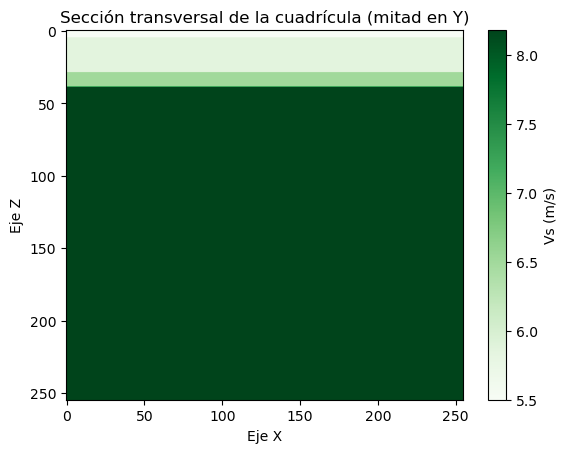

In [8]:
slice_index = eq.ny // 2  # Tomar una rebanada en la mitad de la cuadrícula a lo largo del eje Y
plt.imshow(gridp.array[:, slice_index, :].T, cmap='Greens', origin='upper', aspect='auto')
plt.colorbar(label='Vs (m/s)')
plt.title('Sección transversal de la cuadrícula (mitad en Y)')
plt.xlabel('Eje X')
plt.ylabel('Eje Z')
plt.show()

### Then we just use the method for Fast marching as all the necesary variables are stored inside the class

In [9]:
tps = eq.eqnefmm()

#### Countor plot

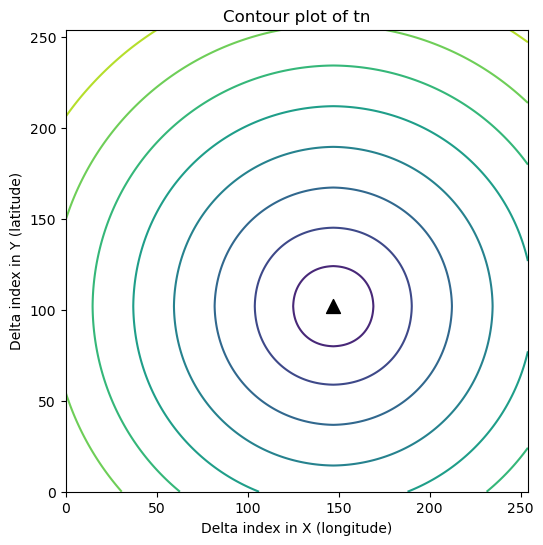

In [12]:
# Plot contour times plot
tn = tps[:,:,1]

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111,aspect=1.0)
plt.contour(tn, levels=np.linspace(tn.min(), tn.max(), 10))
plt.scatter(eq.stax_pro,eq.stay_pro,s=100,marker='^',color='black', label='CI.CLC')
plt.xlabel('Delta index in X (longitude)')
plt.ylabel('Delta index in Y (latitude)')
plt.title('Contour plot of tn')

# Show the plot
plt.show()

#### 3D Plot

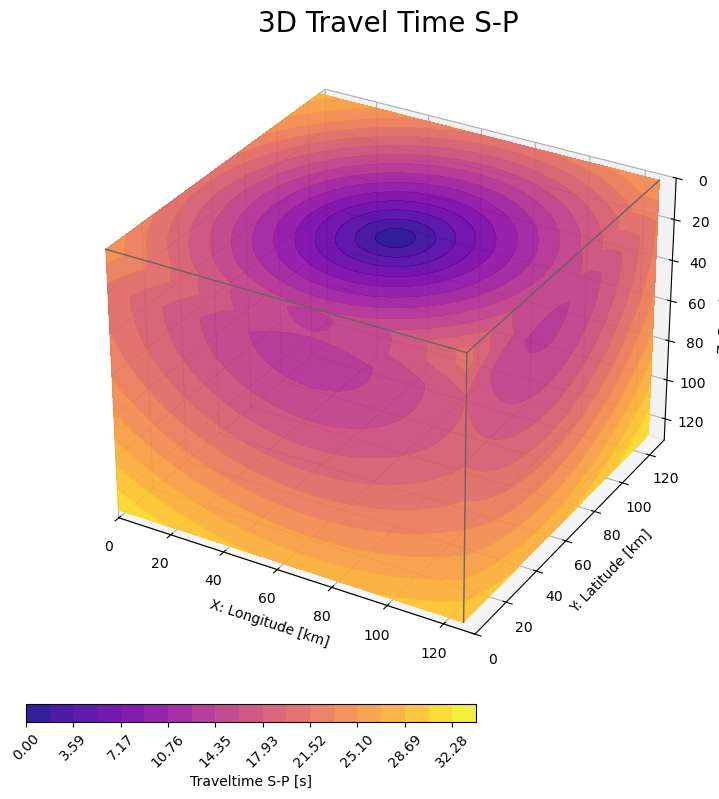

In [14]:
#Modified from Yangkang Chen, 2022. The University of Texas at Austin.

# Define matrix dimensions
Nx, Ny, Nz = eq.nx, eq.ny, eq.nz
X, Y, Z = np.meshgrid(np.arange(Nx)*.5, np.arange(Ny)*.5, np.arange(Nz)*.5)

# Specify the 3D data
data = tps
kw = {
    'vmin': data.min(),
    'vmax': data.max(),
    'alpha': 0.9,
    'levels': np.linspace(data.min(), data.max(), 20),
}

# Create a figure with 3D axes
fig = plt.figure(figsize=(18, 9))
# plt.subplot(1,2,1)
plt.plasma()
ax = fig.add_subplot(121, projection='3d')

# Plot contour surfaces
_ = ax.contourf(X[:, :, -1], Y[:, :, -1], data[:, :, 0], zdir='z', offset=0, **kw)
_ = ax.contourf(X[0, :, :], data[0, :, :], Z[0, :, :], zdir='y', offset=0, **kw)
C = ax.contourf(data[:, -1, :], Y[:, -1, :], Z[:, -1, :], zdir='x', offset=X.max(), **kw)

# Set limits of the plot from coordinates limits
xmin, xmax = X.min(), X.max()
ymin, ymax = Y.min(), Y.max()
zmin, zmax = Z.min(), Z.max()
ax.set(xlim=[xmin, xmax], ylim=[ymin, ymax], zlim=[zmin, zmax])

#Plot edges
edges_kw = dict(color='0.4', linewidth=1, zorder=1e3)
ax.plot([xmax, xmax], [ymin, ymax], 0, **edges_kw)
ax.plot([xmin, xmax], [ymin, ymin], 0, **edges_kw)
ax.plot([xmax, xmax], [ymin, ymin], [zmin, zmax], **edges_kw)

# Set labels and zticks
#ax.set(xlabel='X: Longitude [km]', ylabel='Y: Latitude [km]', zlabel='Z: Depth [km]')
ax.set_xlabel('X: Longitude [km]')
ax.set_ylabel('Y: Latitude [km]')
ax.set_zlabel('Z: Depth [km]')

# Set zoom and angle view
# ax.view_init(40, -30, 0)
# ax.set_box_aspect(None, zoom=0.9)         stax_pro,stay_pro

#plt.gca().scatter(stax_pro, stay_pro, 0, s=100, marker='^', color='black', label='CI.CLC') #(x, y, z)
plt.gca().set_xlim(0,131);
plt.gca().set_ylim(0,131);
plt.gca().set_zlim(0,131)
plt.title('3D Travel Time S-P', color='k', fontsize=20)
plt.gca().invert_zaxis()

# Position for the colorbar
#cb = plt.colorbar(C, cax = fig.add_axes([0.15,0.1,0.3,0.02]), format= "%4.2f", orientation='horizontal',label='Traveltime S-P [s]')
cb = plt.colorbar(C, cax=fig.add_axes([0.10, 0.09, 0.25, 0.02]), format="%4.2f", orientation='horizontal', label='Traveltime S-P [s]')
cb.ax.tick_params(labelrotation=45)
# Save image plot
#plt.savefig('test_pyekfmm_fig2.png',format='png',dpi=300,bbox_inches='tight', pad_inches=0.3)
#plt.savefig('test_pyekfmm_fig2.pdf', format='pdf', dpi=350, bbox_inches='tight', pad_inches=0.1)


# Show Figure
plt.show()